In [1]:
import pandas as pd
import numpy as np
import os 

from darts.models import TFTModel
import darts.timeseries as timeseries
from torch.nn import MSELoss
from darts import TimeSeries, concatenate
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mse

from darts.utils.timeseries_generation import datetime_attribute_timeseries

import lightning.pytorch as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
# from pytorch_forecasting.data import TimeSeriesDataLoader
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning import Trainer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss


import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv(os.path.join("prcs_data", 'ml_train_data.csv'))
display(data.describe())
data = data.applymap(lambda x: 0.01 if isinstance(x, (int, float)) and x <= 0 else x)
data.describe()

,GSE_WSE,WLM_RPE,WSE,RPE_WSE,WLM_GSE,YEAR
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,30.310606,564.791247,532.154673,32.093048,563.004427,2016.500000
std,19.858979,1481.690859,1488.606372,19.727206,1481.374740,4.032129
min,-2.439000,3.310250,-138.164000,-0.039000,1.401083,2010.000000
25%,14.342678,31.605607,1.642632,15.789169,30.198152,2013.000000
50%,26.116486,78.017067,49.615313,27.417132,76.626472,2016.500000
75%,44.785022,191.697334,148.662442,46.645401,189.696077,2020.000000
max,145.064000,5478.792000,5487.949000,148.464000,5475.833000,2023.000000


C:\Users\EndUser\AppData\Local\Temp\ipykernel_2260\2879152883.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 0.01 if isinstance(x, (int, float)) and x <= 0 else x)


,GSE_WSE,WLM_RPE,WSE,RPE_WSE,WLM_GSE,YEAR
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,30.317676,564.791247,533.761573,32.093150,563.004427,2016.500000
std,19.847780,1481.690859,1488.007380,19.727039,1481.374740,4.032129
min,0.010000,3.310250,0.005214,0.010000,1.401083,2010.000000
25%,14.342678,31.605607,1.642632,15.789169,30.198152,2013.000000
50%,26.116486,78.017067,49.615313,27.417132,76.626472,2016.500000
75%,44.785022,191.697334,148.662442,46.645401,189.696077,2020.000000
max,145.064000,5478.792000,5487.949000,148.464000,5475.833000,2023.000000


In [3]:
data_train = data[data['YEAR']!=2023]
data_test = data[data['YEAR']==2023]

data_train['MSMT_DATE'] = pd.to_datetime(data_train.MSMT_DATE)
data_train

C:\Users\EndUser\AppData\Local\Temp\ipykernel_2260\1558515881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['MSMT_DATE'] = pd.to_datetime(data_train.MSMT_DATE)


,COUNTY_NAME,MSMT_DATE,GSE_WSE,WLM_RPE,WSE,RPE_WSE,WLM_GSE,YEAR
0,Butte,2010-01-01,22.817364,141.474082,111.787182,25.628727,138.772449,2010
1,Butte,2010-02-01,21.131488,141.474082,114.975488,23.863814,138.772449,2010
2,Butte,2010-03-01,19.862488,142.258000,114.174256,22.703186,139.574400,2010
3,Butte,2010-04-01,20.008182,142.258000,115.047500,22.825227,139.574400,2010
4,Butte,2010-05-01,22.282568,142.258000,112.773114,25.099614,139.574400,2010
...,...,...,...,...,...,...,...,...
1999,Yuba,2022-08-01,45.583333,88.552222,42.127111,46.425111,87.710444,2022
2000,Yuba,2022-09-01,41.388111,88.552222,46.322333,42.229889,87.710444,2022
2001,Yuba,2022-10-01,36.193556,88.552222,51.516889,37.035333,87.710444,2022
2002,Yuba,2022-11-01,34.226222,88.552222,53.484222,35.068000,87.710444,2022


# Darts Implementation

In [4]:
series_dict = {}
for county in data.COUNTY_NAME.unique():
    temp = data[data['COUNTY_NAME']==county]
    train_series = timeseries.TimeSeries.from_dataframe(df=temp,
                                                        time_col = "MSMT_DATE",
                                                        value_cols = ['GSE_WSE', 'WLM_RPE', 'WSE', 'RPE_WSE', 'WLM_GSE'],
                                                        fill_missing_dates=True, freq=None)
    series_dict[county] = train_series



In [5]:
training_cutoff = pd.Timestamp("2022-12-01")


In [14]:
# target = train_series_ls[0]['GSE_WSE']
# past_cov = train_series_ls[0][['WLM_RPE', 'WSE', 'RPE_WSE', 'WLM_GSE']]

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

input_chunk_length = 24
forecast_horizon = 12


model_dict = {}

train_dict = {}
val_dict = {}

series_trnsfrm_dict = {}

transformer_dict = {}
covariates_transformed_dict = {}

train_mse_dict = {}
train_mape_dict = {}
test_mse_dict = {}
test_mape_dict = {}


for county, series in series_dict.items():
    train, val = series.split_after(training_cutoff)

    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    series_transformed = transformer.transform(series)

    covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
    covariates = covariates.stack(
        datetime_attribute_timeseries(series, attribute="month", one_hot=False)
    )
    covariates = covariates.stack(
        TimeSeries.from_times_and_values(
            times=series.time_index,
            values=np.arange(len(series)),
            columns=["linear_increase"],
        )
    )
    covariates = covariates.astype(np.float32)
    scaler_covs = Scaler()
    cov_train, cov_val = covariates.split_after(training_cutoff)
    scaler_covs.fit(cov_train)
    covariates_transformed = scaler_covs.transform(covariates)
    my_model = TFTModel(input_chunk_length=input_chunk_length,
                        output_chunk_length=forecast_horizon,
                        hidden_size=64,
                        lstm_layers=1,
                        num_attention_heads=4,
                        dropout=0.1,
                        batch_size=12,
                        n_epochs=100,
                        add_relative_index=False,
                        add_encoders=None,
                        likelihood=QuantileRegression(
                            quantiles=quantiles
                        ),  # QuantileRegression is set per default
                        loss_fn=MSELoss(),
                        random_state=42,
                        )

    my_model.fit(train_transformed['GSE_WSE'], 
                 past_covariates=train_transformed[['WLM_RPE', 'WSE', 'RPE_WSE', 'WLM_GSE']],
                 future_covariates=covariates_transformed, 
                 verbose=True)

    historical_forecast = my_model.historical_forecasts(
    train_transformed['GSE_WSE'],
    past_covariates = train_transformed[['WLM_RPE', 'WSE', 'RPE_WSE', 'WLM_GSE']],
    future_covariates=covariates_transformed,
    start=0.8,  # Start evaluation at 80% of the dataset
    retrain=False,  # Use the already trained model
    )

    train_mse = mse(train_transformed["GSE_WSE"], historical_forecast)
    train_mse_dict[county] = train_mse

    try:
        train_mape = mape(train_transformed["GSE_WSE"], historical_forecast)
        train_mape_dict[county] = train_mape
    except ValueError:
        continue

    prediction = my_model.predict(n=12, 
                                  num_samples=1,)
    
    test_mse = mse(val_transformed["GSE_WSE"], prediction)
    test_mse_dict[county] = test_mse


    try:
        test_mape = mape(val_transformed["GSE_WSE"], historical_forecast)
        test_mape_dict[county] = test_mape
    except ValueError:
        continue
    

    model_dict[county] = my_model
    train_dict[county] = train_transformed
    val_dict[county] = val_transformed
    series_trnsfrm_dict[county] = series_transformed
    transformer_dict[county] = transformer
    covariates_transformed_dict[county] = covariates_transformed

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn                       | _VariableSelectionNetw

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ValueError: `actual_series` must be strictly positive to compute the MAPE.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ValueError: `actual_series` must be strictly positive to compute the MAPE.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\EndUser\anaconda3\envs\waterfinder_2\Lib\site-packages\darts\metrics\metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Butte


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\EndUser\AppData\Local\Temp\ipykernel_2260\2741297239.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_db = pd.concat([out_db, temp_df])
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Colusa


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Glenn


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Plumas


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Shasta


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Solano


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sutter


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Tehama


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Yolo


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Yuba


Predicting: |          | 0/? [00:00<?, ?it/s]

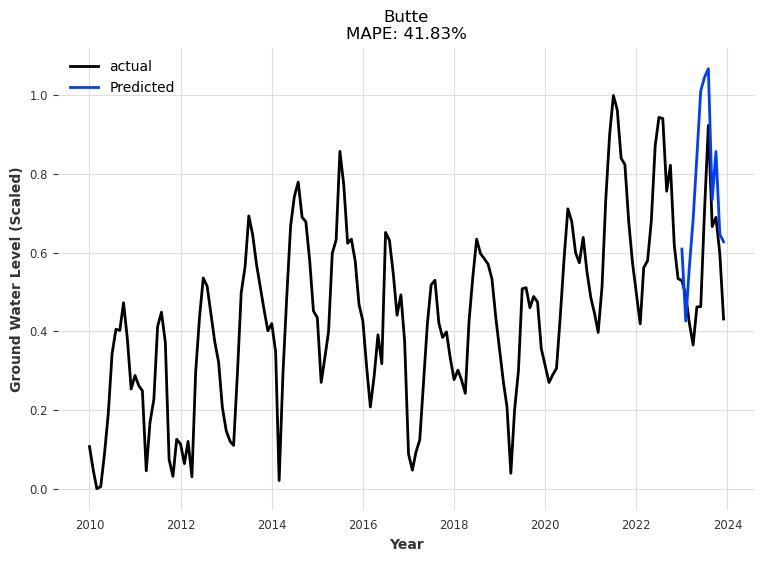

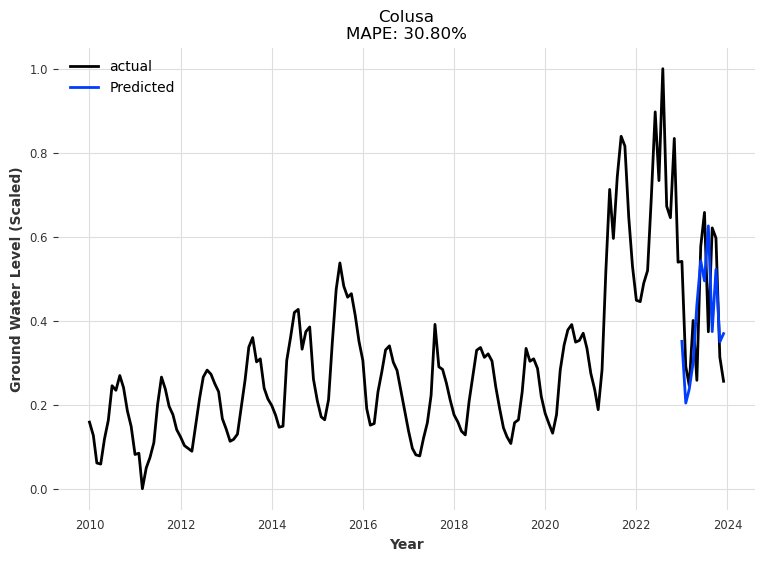

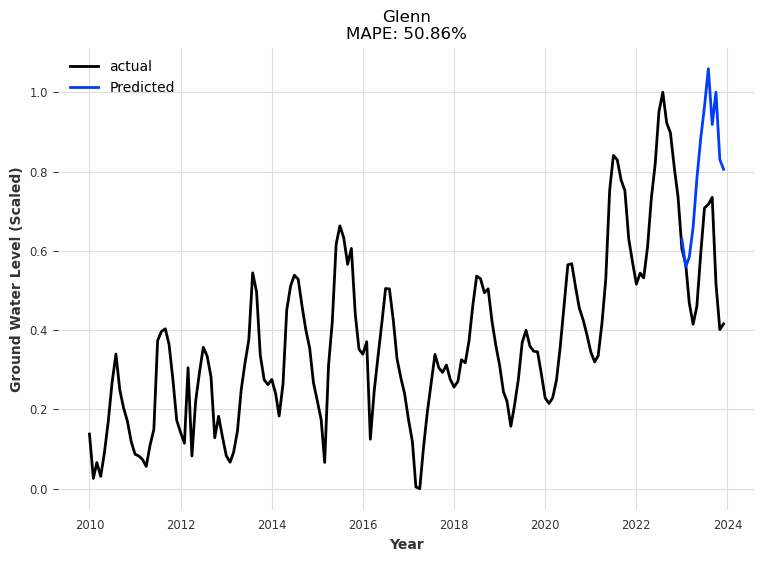

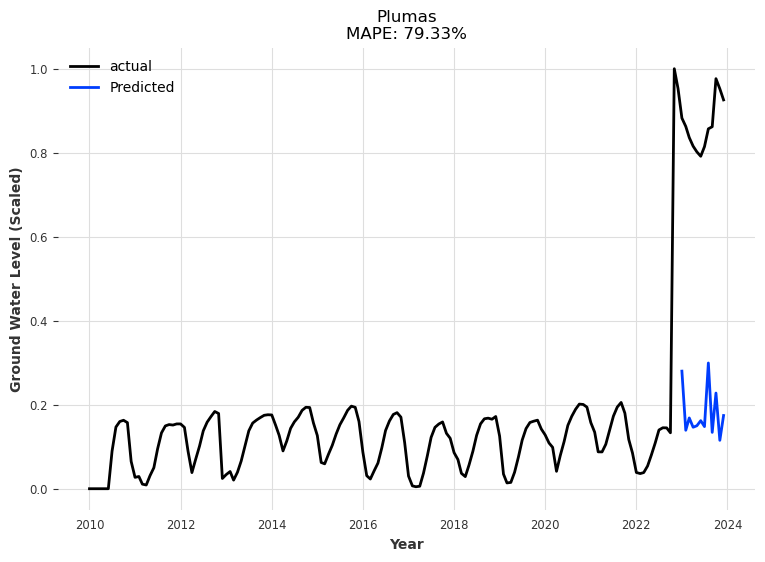

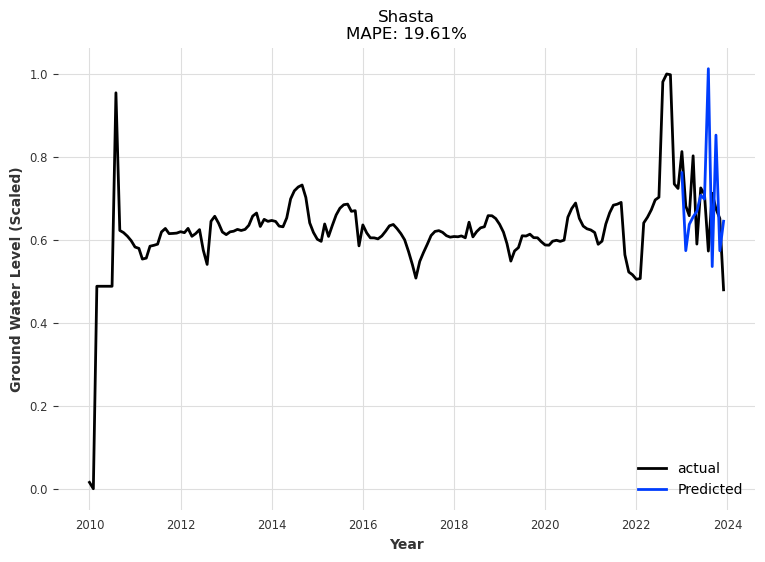

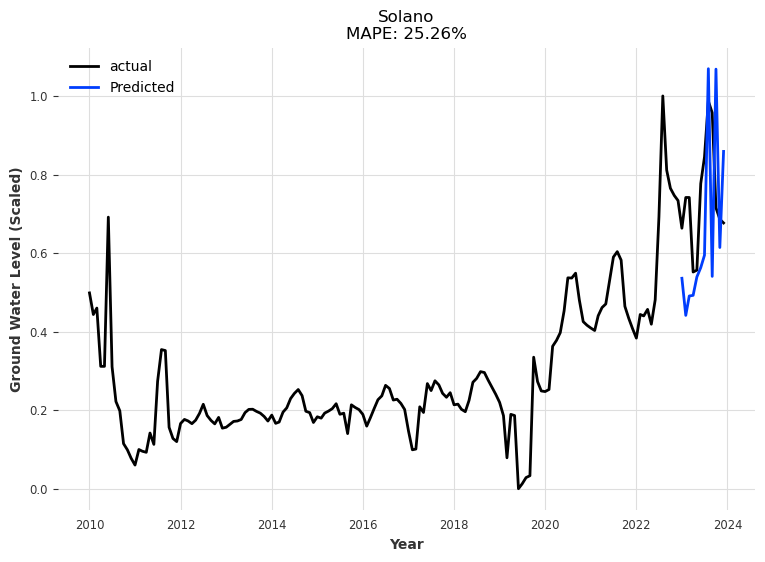

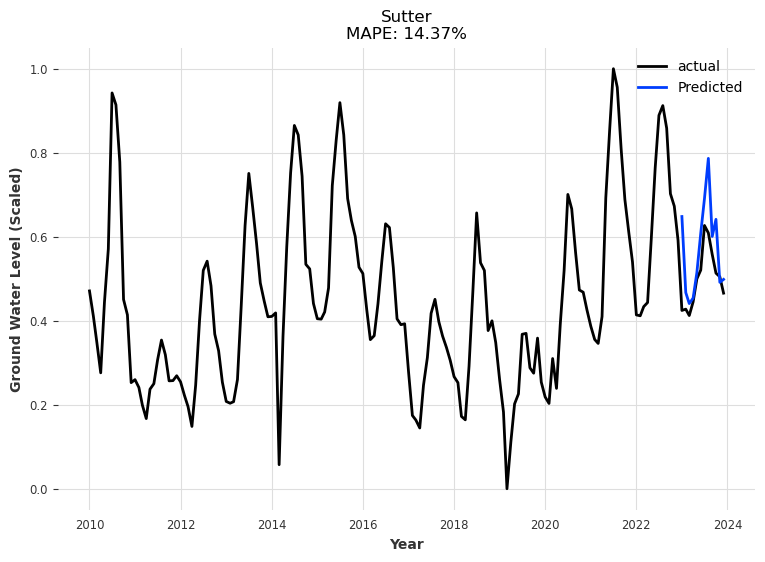

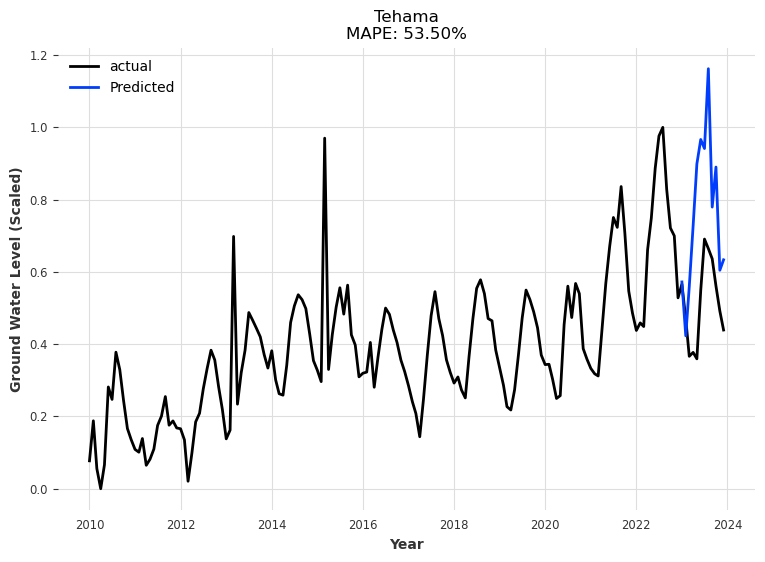

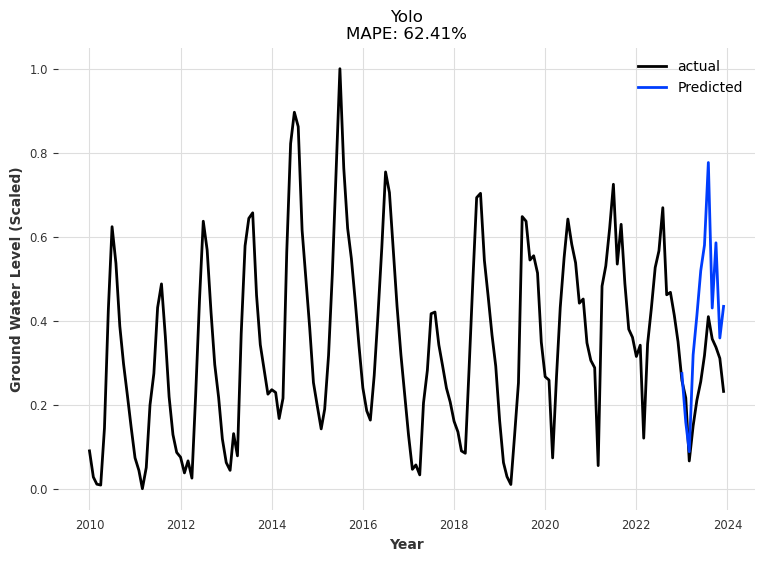

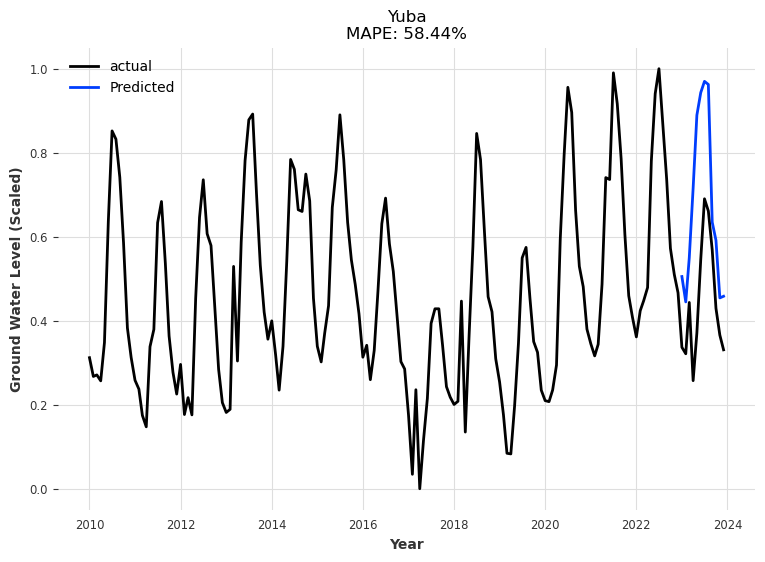

In [15]:
figsize = (9, 6)
out_db = pd.DataFrame(columns=['COUNTY_NAME', 'MSMT_DATE', 'PREDICTED_VALUES'])
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

def eval_model(model, n, actual_series, val_series, county):
    pred_series = model.predict(n=n, num_samples=1)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series['GSE_WSE'][: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(central_quantile="mean", label="Predicted") 

    plt.title("{}\nMAPE: {:.2f}%".format(county, mape(val_series['GSE_WSE'], pred_series)))
    plt.xlabel('Year')
    plt.ylabel('Ground Water Level (Scaled)')
    plt.legend()
    # plt.savefig(f'{county}_graph.png')

    return pred_series

out_dict = {}
for county, model_x, series_x, val_x in zip(model_dict.keys(), model_dict.values(), series_trnsfrm_dict.values(), val_dict.values()):
    print(county)
    pred_out = eval_model(model_x, 12, series_x, val_x, county)
    out_dict[county] = pred_out
    temp_df = pd.DataFrame(columns=['COUNTY_NAME', 'MSMT_DATE', 'PREDICTED_VALUES', 'Actual_Values'])
    temp_df['PREDICTED_VALUES'] = pred_out.data_array().to_numpy().flatten()
    temp_df['COUNTY_NAME'] = county
    temp_df['MSMT_DATE'] = data_test.MSMT_DATE.unique()
    temp_df['Actual_Values'] = series_x['GSE_WSE'][pred_out.start_time(): pred_out.end_time()].data_array().to_numpy().flatten()
    out_db = pd.concat([out_db, temp_df])